# Polyp Detection / Segmentation

In [4]:
#imports n stuff
import numpy as np
import pandas as pd
#import keras as k
#!pip install tensorflow==2.0.0-alpha0
import tensorflow as tf
import os
from skimage import io
from matplotlib import pyplot as plt
from PIL import Image, ImageFile
import imageio
ImageFile.LOAD_TRUNCATED_IMAGES = True
import random
import gc
import sklearn
#import cv2
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import warnings
warnings.filterwarnings('ignore')
tf.__version__

'2.0.0-alpha0'

## Importing files and converting them to bit array / preprocessing

In [5]:
#get_ipython().system_raw("unrar x ETIS-LaribPolypDB.rar")

In [6]:
def to_pixle_array(filepath):
    im = imageio.imread(filepath)
    imarray = np.array(im)
    return imarray

def to_3_channel(im_array):
    return np.stack((im_array,)*3, axis=-1)

In [7]:
g_truth = []
directory_in_str = 'Ground Truth/'
directory = os.fsdecode(directory_in_str)
for file in os.listdir(directory):
    filename = os.path.join(directory,os.fsdecode(file))
    g_truth.append(to_3_channel(to_pixle_array(filename)))
    continue

g_truth = (np.array(g_truth)/255).astype('float32')
g_truth.shape

(612, 288, 384, 3)

In [8]:
original = []
directory_in_str2 = 'Original/'
directory2 = os.fsdecode(directory_in_str2)

for file2 in os.listdir(directory2):
    filename2 = os.path.join(directory2,os.fsdecode(file2))
    original.append(to_pixle_array(filename2))
    continue
  
original = (np.array(original)/255).astype('float32')
original.shape

(612, 288, 384, 3)

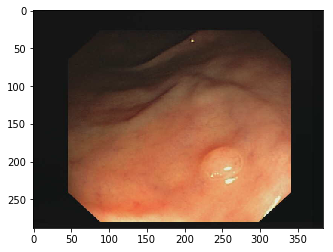

In [9]:
plt.imshow(original[1]);

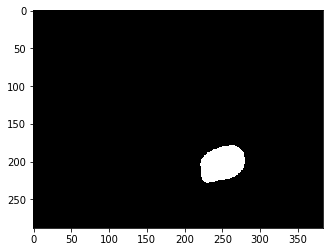

In [10]:
plt.imshow(g_truth[1]);

In [11]:
def overlay(num):
    plt.imshow(g_truth[num], cmap = 'gray')
    plt.imshow(original[num], alpha=.6)
  
interact(overlay, num=30);

interactive(children=(IntSlider(value=30, description='num', max=90, min=-30), Output()), _dom_classes=('widge…

## Segmentation vs Classification vs Recognition


## Transfer learning base

In [12]:
'''from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(original, g_truth, test_size=.25)
INPUT_SHAPE = x_train[0].shape'''

'from sklearn.model_selection import train_test_split\nx_train, x_test, y_train, y_test = train_test_split(original, g_truth, test_size=.25)\nINPUT_SHAPE = x_train[0].shape'

### Building the CNN base from the VGG16 model

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation


In [31]:
basemodel = VGG16(weights='imagenet', include_top=False, input_shape = (150, 150, 3))
basemodel.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [32]:
#basemodel.trainable = False

for layer in basemodel.layers:
    layer.trainable = False

#unfreezing the last convolutional block of the pretrained matrix
print(basemodel.layers[-1].name, " is unfrozen")
basemodel.layers[-1].trainable= True
print(basemodel.layers[-2].name, " is unfrozen")
basemodel.layers[-2].trainable= True
print(basemodel.layers[-3].name, " is unfrozen")
basemodel.layers[-3].trainable= True
print(basemodel.layers[-4].name, " is unfrozen")
basemodel.layers[-4].trainable= True

    
model = Sequential([
    basemodel,
    Flatten(),
    Dropout(.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid'),
])

print('compiling')
model.compile(loss="binary_crossentropy", optimizer = tf.keras.optimizers.SGD(lr=0.0002, momentum=.9), metrics=['accuracy'])



block5_pool  is unfrozen
block5_conv3  is unfrozen
block5_conv2  is unfrozen
block5_conv1  is unfrozen
compiling


In [33]:
BATCH_SIZE = 64
datagen = ImageDataGenerator(rescale=float(1/255), rotation_range=15,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.01,
                               zoom_range=[0.9, 1.25],
                               horizontal_flip=True,
                               vertical_flip=False,
                               fill_mode='reflect',
                               data_format='channels_last',
                               brightness_range=[0.5, 1.5])

train_generator = datagen.flow_from_directory(directory = 'data_polyps/train', class_mode = 'binary', 
                                                    batch_size=BATCH_SIZE, target_size = (150, 150))

val_generator = datagen.flow_from_directory(directory = 'data_polyps/validation', class_mode = 'binary', 
                                                    batch_size=BATCH_SIZE, target_size = (150, 150))


Found 910 images belonging to 2 classes.
Found 302 images belonging to 2 classes.


In [ ]:
step_size_train = train_generator.n//train_generator.batch_size
step_size_valid = val_generator.n//val_generator.batch_size

history = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   validation_data = val_generator,
                   validation_steps = step_size_valid,
                   epochs=32)

Epoch 1/32
14/14 [==============================] - 77s 5s/step - loss: 0.9029 - accuracy: 0.4835 - val_loss: 0.7439 - val_accuracy: 0.5039
Epoch 2/32
14/14 [==============================] - 74s 5s/step - loss: 0.7024 - accuracy: 0.5792 - val_loss: 0.6814 - val_accuracy: 0.5430
Epoch 3/32
14/14 [==============================] - 75s 5s/step - loss: 0.6584 - accuracy: 0.6489 - val_loss: 0.5837 - val_accuracy: 0.6836
Epoch 4/32
14/14 [==============================] - 78s 6s/step - loss: 0.5891 - accuracy: 0.6886 - val_loss: 0.5137 - val_accuracy: 0.7930
Epoch 5/32
14/14 [==============================] - 71s 5s/step - loss: 0.5485 - accuracy: 0.7211 - val_loss: 0.4927 - val_accuracy: 0.7773
Epoch 6/32
14/14 [==============================] - 75s 5s/step - loss: 0.4874 - accuracy: 0.7648 - val_loss: 0.4632 - val_accuracy: 0.7852
Epoch 7/32
14/14 [==============================] - 75s 5s/step - loss: 0.4490 - accuracy: 0.7801 - val_loss: 0.4418 - val_accuracy: 0.7969
Epoch 8/32
14/14 [==

In [ ]:
score = model.evaluate_generator(val_generator, step_size_valid, workers=7)
print('Validation/Test loss    :', score[0])
print('Validation/Test accuracy:', score[1])